In [1]:
import sys
sys.path.append('/users/taoshi11/analysator/')
import pytools as pt
import numpy as np
# import imageio

Using LaTeX formatting
Using backend module://matplotlib_inline.backend_inline
Using matplotlib version 3.8.4


In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

In [3]:
filepath = '/scratch/project_2000203/3D/FHA/bulk1/'
filename = 'bulk1.0001000.vlsv'
name = filepath+filename
f = pt.vlsvfile.VlsvReader(file_name = name)

Found population proton


In [4]:
def to_Re(m):

    Re = 6371000
    return m/Re

In [5]:
[xmin, ymin, zmin, xmax, ymax, zmax] = f.get_spatial_mesh_extent()

[xsize, ysize, zsize] = f.get_spatial_mesh_size()
[xsizefs, ysizefs, zsizefs] = f.get_fsgrid_mesh_size()


simext_m = [xmin,xmax,ymin,ymax,zmin,zmax]
sizes = np.array([xsize,ysize,zsize])
sizesfs = np.array([xsizefs,ysizefs,zsizefs])

simext = list(map(to_Re, simext_m))
    #simext = simext_m

boxcoords = list(simext)


In [7]:
xmin/6371000

-110.50070632553759

In [8]:
Re=6371000
f.get_spatial_mesh_extent()/(Re)

array([-110.50070633,  -57.76173285,  -57.76173285,   50.22759378,
         57.76173285,   57.76173285])

In [9]:
# Sort cellids and connection variable

connection = f.read_variable('vg_connection')
cellids = f.read_variable("CellID")

indexids = cellids.argsort()
cellids = cellids[indexids]
connection = connection[indexids]

# find the cells that vg_connection is 0
connection_zero_indices = np.where(connection==0)[0]
cellids_closed = cellids[connection_zero_indices]


In [10]:
coords_closed = f.read_variable("vg_coordinates",cellids_closed)

# coords_closed = list(map(to_Re, coords_closed))
# coords_closed = np.array(coords_closed)

In [13]:

mid_coords_fl = (coords_closed[1:, :]+ coords_closed[:-1, :]) / 2
mid_coords_fl.shape

(201837, 3)

In [10]:
# # Determine the cell size
# Re = 6371000 # Unit: m
# cell_x = (boxcoords[1]-boxcoords[0])/xsize
# cell_y = (boxcoords[3]-boxcoords[2])/ysize  # Unit: Re
# cell_size = cell_x * cell_y * (Re**2) # Unit: m^2

# cell_z = (boxcoords[5]-boxcoords[4])/zsize
# cell_z

In [11]:
# Determine the cell size
cellsize_closed = f.read_variable("vg_dx",cellids_closed) # Unit: m
cellsize_closed

array([[8000000., 8000000., 8000000.],
       [8000000., 8000000., 8000000.],
       [8000000., 8000000., 8000000.],
       ...,
       [1000000., 1000000., 1000000.],
       [1000000., 1000000., 1000000.],
       [1000000., 1000000., 1000000.]])

In [12]:
# Find the coords that close to equatorial plane
eq_indices = np.where((coords_closed[:,2] < cellsize_closed[:,2]) & (coords_closed[:,2] > 0))[0] # Determine the "close to equatoria" cells
coords_used = coords_closed[eq_indices][:]

In [13]:
cellids_used = cellids_closed[eq_indices]
cellsize_used = cellsize_closed[eq_indices]
cellids_used.shape

(8209,)

In [14]:
cellsize_used[:,0] * cellsize_used[:,1]

array([6.4e+13, 6.4e+13, 6.4e+13, ..., 1.0e+12, 1.0e+12, 1.0e+12])

In [15]:
# Bz in the selected cells, and the corresponding flux
B = f.read_variable("vg_b_vol",cellids_used)
B_mag = np.linalg.norm(B,axis = 1)
Bz = B[:,2]
# Bz[Inside_indices] = 0
cell_size = cellsize_used[:,0] * cellsize_used[:,1]
B_flux = Bz * cell_size # unit: Wb

In [16]:
B_mag.shape

(8209,)

In [17]:
Bflux_total = np.loadtxt('../../output/Bflux/Bflux_total.csv', delimiter=',')
total_flux = np.sum(Bflux_total[:,1:],axis = 1)

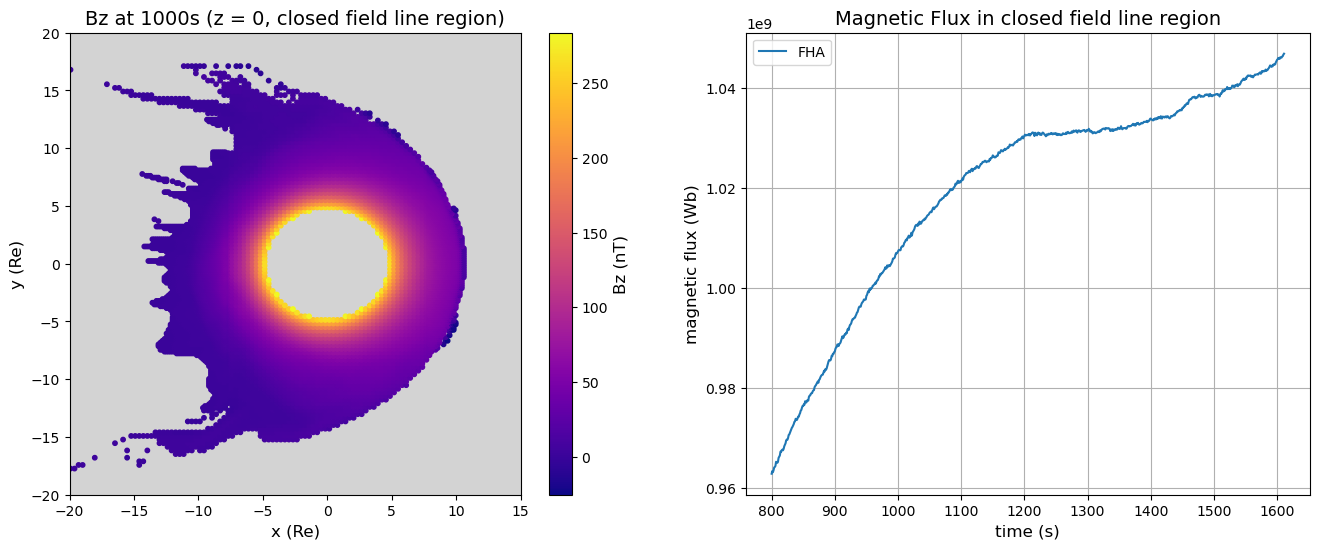

In [18]:
# Bz at 1000s
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors

Re = 6371000

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax1.set_facecolor("lightgrey")

vmin = Bz.min() * 1e9
vmax = Bz.max() * 1e9
vcenter = (vmin+vmax)/2
norm = mcolors.TwoSlopeNorm(vmin=vmin,vcenter = vcenter, vmax=vmax)

scatter = ax1.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=Bz * 1e9,norm = norm,cmap = 'plasma',s = 10)
ax1.set_xlim([-20,15])
ax1.set_xlabel('x (Re)', fontsize = 12)
ax1.set_ylabel('y (Re)', fontsize = 12)
colorbar = plt.colorbar(scatter,ax=ax1)
colorbar.set_label('Bz (nT)', fontsize = 12)

ax1.set_title('Bz at 1000s (z = 0, closed field line region)',fontsize = 14)
ax1.set_ylim([-20,20])

ax2 = fig.add_subplot(122)
ax2.plot(Bflux_total[:,0],total_flux,label = 'FHA')
ax2.set_ylabel('magnetic flux (Wb)', fontsize = 12)
ax2.set_xlabel('time (s)',fontsize = 12)
ax2.set_title('Magnetic Flux in closed field line region', fontsize = 14)
ax2.grid(True)


plt.legend()

plt.savefig('../../output/Bflux/closed_Bz_flux.png')
plt.show()

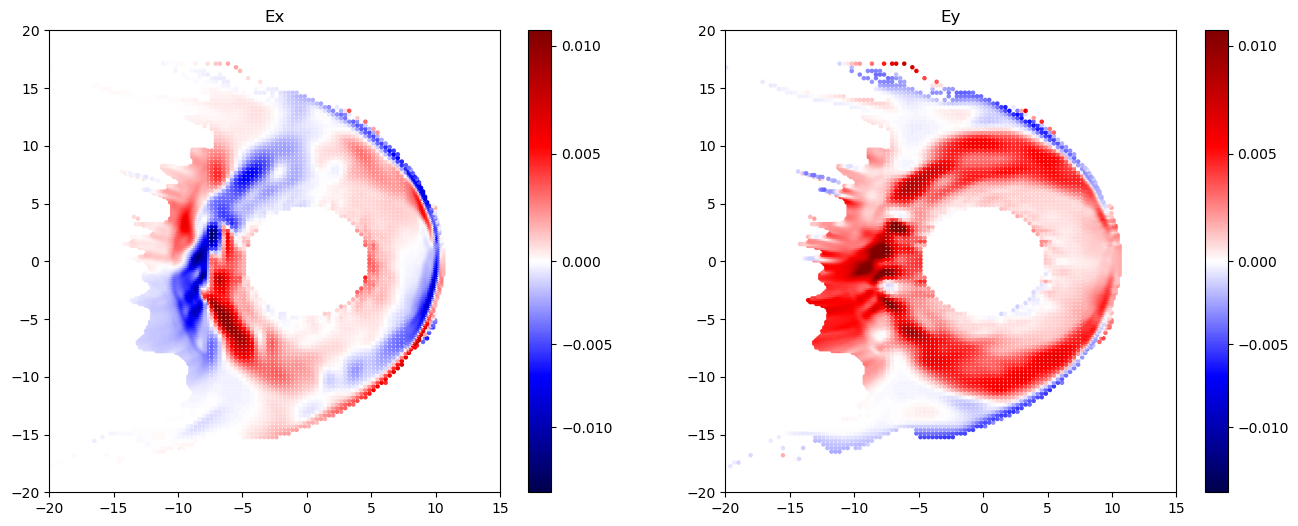

In [19]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as mcolors
Re = 6371000
v = f.read_variable("proton/vg_v",cellids_used)
E = f.read_variable("vg_e_vol",cellids_used)

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)

vmin = E[:,0].min()
vmax = E[:,0].max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

scatter = ax1.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=E[:,0],norm = norm,cmap = 'seismic',s = 5)
ax1.set_xlim([-20,15])
colorbar = plt.colorbar(scatter,ax=ax1)
ax1.set_title('Ex')
ax1.set_ylim([-20,20])


ax2 = fig.add_subplot(122)
scatter = ax2.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=E[:,1],norm = norm,cmap = 'seismic',s = 5)
ax2.set_xlim([-20,15])
ax2.set_ylim([-20,20])
colorbar = plt.colorbar(scatter,ax=ax2)
ax2.set_title('Ey')

plt.show()

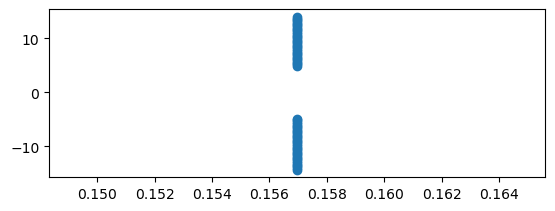

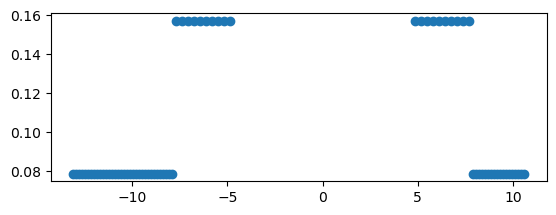

In [21]:
indice_dawn_dusk = np.where((coords_used[:,0]<cellsize_used[:,0]) & (coords_used[:,0]>0))[0]
indice_noon_midnight = np.where((coords_used[:,1]<cellsize_used[:,1]) & (coords_used[:,1]>0))[0]

plt.subplot(211)
plt.scatter(coords_used[indice_dawn_dusk,0]/Re,coords_used[indice_dawn_dusk,1]/Re)
plt.show()
plt.subplot(212)
plt.scatter(coords_used[indice_noon_midnight,0]/Re,coords_used[indice_noon_midnight,1]/Re)
plt.show()

In [22]:
# Determine the dawn dusk convection rate
convection_rate_dd = np.zeros((len(indice_dawn_dusk)))
for i in range(len(indice_dawn_dusk)):
    indice_tmp = indice_dawn_dusk[i]
    convection_rate_dd[i] = E[indice_tmp,1]*cellsize_used[indice_tmp,1]
coords_dawndusk = coords_used[indice_dawn_dusk,:]

# Determine the noon midnight convection rate
convection_rate_nm = np.zeros((len(indice_noon_midnight)))
# See if Ey is significant here
convection_rate_nmy = np.zeros((len(indice_noon_midnight)))

for j in range(len(indice_noon_midnight)):
    indice_tmp = indice_noon_midnight[j]
    convection_rate_nm[j] = E[indice_tmp,0]*cellsize_used[indice_tmp,0]
    convection_rate_nmy[j] = E[indice_tmp,1]*cellsize_used[indice_tmp,1]
coords_noonmidnight = coords_used[indice_noon_midnight,:]

print(convection_rate_nm)
print(convection_rate_dd)

[ -8140.98119736   6314.77963179   6482.88289085   3992.49093607
   5728.74210775   8566.32739305   7598.54679927   6285.82341596
   4841.20380133   3454.73433845   6705.75676486   5383.43703374
   3666.21324793   2778.70055288   2439.81112726   1975.38174689
   1287.96254285    484.53762429    -48.67141615   -263.4798584
    227.9667533     276.9351704     263.72240973    249.01330471
    254.62501799    274.59466946    295.85955781    322.71776581
    357.15723061    416.14926886    468.42746087    500.76621119
    523.98769185    587.79073879    722.41999442    802.41420073
    716.09235601    865.71509019   1194.05891746   1497.1854398
   1219.85771693    898.0143466     544.46363356   -234.07458502
  -1448.19077104  -3123.2717447   -5649.61135387  -8800.2840057
 -11071.87289745 -11205.18706739 -10548.49848151  -9325.49312711
  -9653.07094157  -8559.5343262    -168.72989363   -179.5306016
   -200.45366546   -247.84941343   -277.04625973   -287.55707899
   -291.11231561   -509.56371

In [23]:
coords_noonmidnight.shape
noon = np.where(coords_noonmidnight[:,0] > 0)[0]
midnight = np.where(coords_noonmidnight[:,0] < 0)[0]
noon.shape
coords_noonmidnight[midnight,0]/Re
# sorted(coords_noonmidnight[midnight,0]/Re)
a = np.column_stack((coords_noonmidnight[midnight,0],convection_rate_nm[midnight]))
a = a[a[:,0].argsort()]

dawn = np.where(coords_dawndusk[:,1] < 0)[0]
dusk = np.where(coords_dawndusk[:,1] > 0)[0]

In [24]:
convection_rate_dd[dusk]

array([ 2013.53267767,  2578.54233496,  2384.57275555,  1901.12565178,
        2396.00683562,  2917.95865633,  4100.38093105,  6839.70563114,
        9338.69183064,  9395.03125846,  8224.08497334,  6947.57374004,
        6010.23528725,  5988.63931373,  6990.53844437,  8975.50676018,
       11236.32397503, 12001.85343623, 11083.8310793 ,  8422.13351279,
        4655.09761125,  1265.22488426, -1349.31039065, -2777.84024365,
       -2711.90772764, -2056.78050406, -1865.52375089, -2435.83973497,
       -4437.14438006, -7569.87789646])

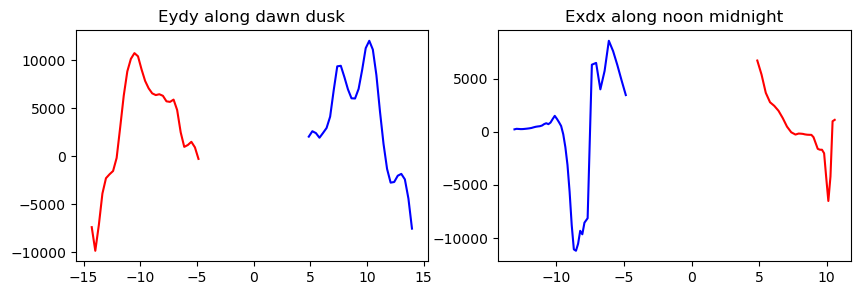

In [25]:
convection_rate_dd.shape
coords_dawndusk.shape

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(121)

ax1.plot(coords_dawndusk[dawn,1]/Re,convection_rate_dd[dawn],'r')
ax1.plot(coords_dawndusk[dusk,1]/Re,convection_rate_dd[dusk],'b')
ax1.set_title('Eydy along dawn dusk')

ax2=fig.add_subplot(122)
ax2.plot(coords_noonmidnight[noon,0]/Re,convection_rate_nm[noon],'r')
ax2.plot(a[:,0]/Re,a[:,1],'b')
ax2.set_title('Exdx along noon midnight')
# plt.plot(coords_noonmidnight[midnight,0]/Re,convection_rate_nm[midnight])
plt.show()

In [26]:
# Flux transport rate between each MLT sectors
def flux_transport_rate(f,coords,cellids):

    # Determine Er and Etheta
    E = f.read_variable("vg_e_vol",cellids)
    Ex, Ey = E[:,0], E[:,1]
    x,y = coords[:,0], coords[:,1]

    theta = np.arctan2(y,x)
    Er = Ex * np.cos(theta)+ Ey * np.sin(theta)
    Etheta = -Ex * np.sin(theta) + Ey * np.cos(theta)
    return Er,Etheta

Er,Etheta = flux_transport_rate(f,coords_used,cellids_used)

In [27]:
bound_layer = f.read_variable("vg_boundarylayer",cellids_used)
bound_type = f.read_variable("vg_boundarytype", cellids_used)

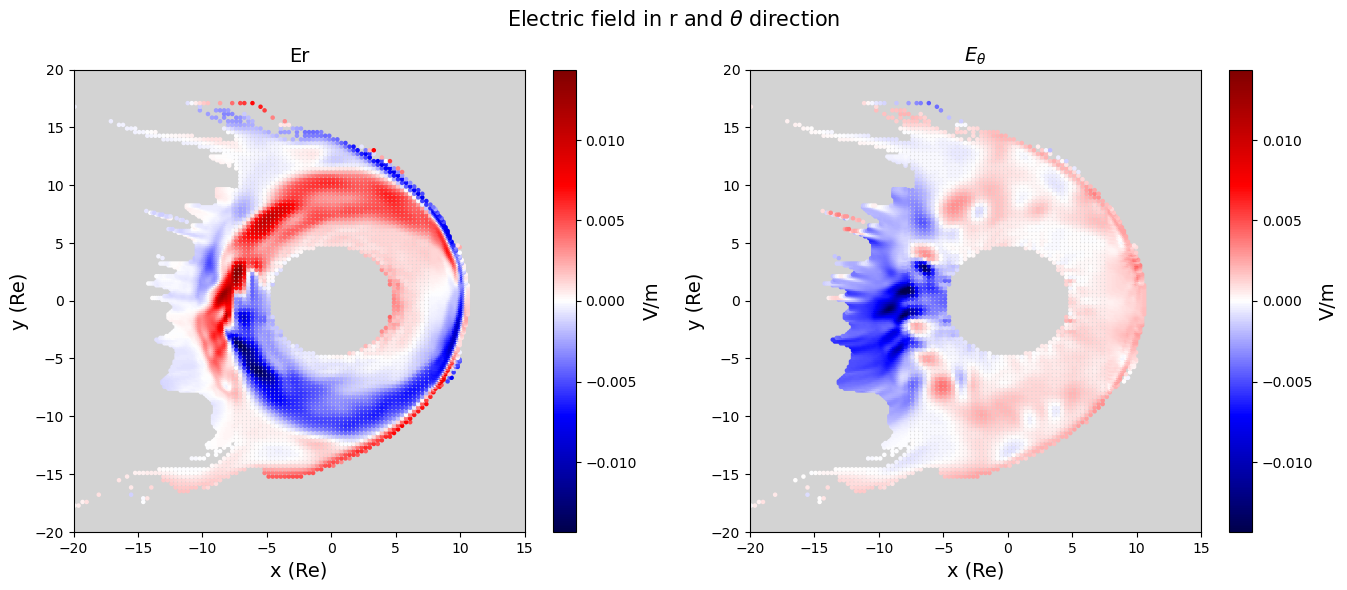

In [28]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax1.set_facecolor("lightgrey")

vmin1 = Er.min()
vmax1 = Er.max()
norm1 = mcolors.TwoSlopeNorm(vmin=vmin1, vcenter=0, vmax=vmax1)

scatter = ax1.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=Er,norm = norm1,cmap = 'seismic',s = 5)
ax1.set_xlim([-20,15])
ax1.set_ylim([-20,20])
ax1.set_xlabel('x (Re)', fontsize = 14)
ax1.set_ylabel('y (Re)', fontsize = 14)
colorbar1 = plt.colorbar(scatter,ax=ax1)
colorbar1.set_label('V/m',fontsize = 14)
ax1.set_title('Er',fontsize = 14)


ax2 = fig.add_subplot(122)
ax2.set_facecolor("lightgrey")


# vmin2 = Etheta.min()
# vmax2 = Etheta.max()
# norm2 = mcolors.TwoSlopeNorm(vmin=vmin2, vcenter=0, vmax=vmax2)

scatter = ax2.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=Etheta,norm = norm1,cmap = 'seismic',s = 5)
ax2.set_xlim([-20,15])
ax2.set_ylim([-20,20])
ax2.set_xlabel('x (Re)',fontsize = 14)
ax2.set_ylabel('y (Re)',fontsize = 14)
colorbar2 = plt.colorbar(scatter,ax=ax2)
colorbar2.set_label('V/m',fontsize = 14)
ax2.set_title(r'$E_\theta$',fontsize = 14)

fig.suptitle(r"Electric field in r and $\theta$ direction",fontsize = 15)

# ax3 = fig.add_subplot(223)
# scatter = ax3.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=bound_layer,s = 5)
# ax3.set_xlim([-20,15])
# ax3.set_ylim([-20,20])
# colorbar = plt.colorbar(scatter,ax=ax3)
# ax3.set_title('boundary layer')

# ax4 = fig.add_subplot(224)
# scatter = ax4.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=bound_type,s = 5)
# ax4.set_xlim([-20,15])
# ax4.set_ylim([-20,20])
# colorbar = plt.colorbar(scatter,ax=ax4)
# ax4.set_title('boundary type')


fig.savefig("../../output/Bflux/Er_Etheta.png")
plt.show()

In [ ]:
def transform_to_polar(coords):
    x, y = coords[:, 0], coords[:, 1]
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta


In [ ]:
def get_MLT_value(f,cellids):
    coords = f.read_variable("vg_coordinates",cellids)
    xx, yy = coords[:, 0], coords[:, 1]
    MLT_values = np.zeros((coords.shape[0]))

    for i in range(len(xx)):
        x, y = xx[i], yy[i]

        if x == 0:
            if y > 0:
                MLT = 18
            elif y < 0:
                MLT = 6
        else:
            angle = np.arctan2(y, x)
            MLT = 12 + angle * (12/np.pi)

        MLT_values[i] = MLT

    return MLT_values

In [ ]:
def find_boundary_points(coords, estimated_radius, tolerance,cellids):
    MLT_values = get_MLT_value(coords)
    r, theta = transform_to_polar(coords)
    
#     sort theta
    idx_theta = np.argsort(theta)
    

    boundary_indices = np.where((r >= estimated_radius - tolerance) & (r <= estimated_radius + tolerance))[0]
    boundary_points = coords[boundary_indices]
    boundary_r = r[boundary_indices]
    boundary_theta = theta[boundary_indices]
    boundary_cellids = cellids[boundary_indices]
    boundary_MLTs = MLT_values[boundary_indices]

    return boundary_r, boundary_theta, boundary_cellids,boundary_indices,boundary_MLTs

In [ ]:
Re = 6371000
tol = 0.1*Re
estimated_radius = 5*Re
bound_r,bound_theta,bound_cellids,bound_indice,bound_MLTs = find_boundary_points(coords_used,estimated_radius,tol,cellids_used)
bound_coords = f.read_varaible("vg_coordinates",bound_cellids)

In [ ]:
x = np.array([-3, 1, 2])
x[np.argsort(x)]


In [ ]:
indice_small2large = np.argsort(bound_theta)

In [ ]:
bound_r_new = bound_r[indice_small2large]
bound_theta_new = bound_theta[indice_small2large]
bound_cellids_new = bound_cellids[indice_small2large]

In [ ]:
points = f.read_variable("vg_coordinates",bound_cellids_new)
points1 = points[0:-1]
points2 = points[1:]

In [ ]:
bound_cellids_new

In [ ]:
b = np.array([1,2,3])
c = np.array([2,3,4])
np.hstack((b,c))

In [ ]:
cellids_crossed = []
distances_crossed = []
Etheta_dtheta = []

for i in range(points.shape[0]-1):
    point1_tmp = points1[i,:]
    point2_tmp = points2[i,:]
    a = get_cellids_coordinates_distances(f,point1_tmp,point2_tmp)
    Etheta_tmp,Ethetadtheta_tmp = radial_convection_rate(f,a[2],a[0],a[1])
    cellids_crossed = np.hstack((cellids_crossed,a[0]))
    distances_crossed = np.hstack((distances_crossed,a[1]))
    Etheta_dtheta= np.hstack((Etheta_dtheta_crossed,Ethetadtheta_tmp))


#     print(sum0)
#     print(a[0])
#     print(a[1])

In [ ]:
MLT_corresponded = get_MLT_value(f,cellids_crossed)
idx_36 = np.where((MLT_corresponded >= 3) & (MLT_corresponded < 6))[0]
Etheta_dtheta_crossed_36 = Etheta_dtheta[idx_36]
Etheta_dtheta_crossed_36.sum()

In [ ]:
def radial_convection_rate(f,coords,cellids,distances):
    
    E = f.read_variable("vg_e_vol", cellids)
    l_cell = f.read_variable("vg_dx",cellids)
    
    Ex, Ey = E[:,0], E[:,1]
    x, y = coords[:,0], coords[:,1]
    theta = np.arctan2(y,x)
#     delta_x,delta_y = l_cell[:,0]/2,l_cell[:,1]/2
#     diagonal = np.sqrt(delta_x**2+delta_y**2)
    
#     dtheta = diagonal/r
    

#     print(Ex,Ey)

    Etheta = -Ex * np.sin(theta) + Ey * np.cos(theta)

    

#     Etheta_dtheta = Etheta * r * dtheta
    Etheta_dtheta = Etheta * distances

    return Etheta,Etheta_dtheta


In [ ]:
# bound_cellids
# Etheta_new,Ethetadtheta = radial_convection_rate(f,bound_r,bound_theta,bound_cellids)
Etheta_new,Ethetadtheta = radial_convection_rate(f,bound_coords,bound_cellids_new,distances)


In [ ]:
Etheta_dtheta

In [ ]:
MLT_03_indices = np.where((bound_MLTs>=0) & (bound_MLTs<=3))[0]
conv_rate_theta_03 = np.sum(Ethetadtheta[MLT_03_indices])
conv_rate_theta_03
np.sum(Ethetadtheta)

In [ ]:
coords_bound = f.read_variable("vg_coordinates",bound_cellids_new)

vmin3 = Etheta_new.min()
vmax3 = Etheta_new.max()
norm3 = mcolors.TwoSlopeNorm(vmin=vmin3, vcenter=0, vmax=vmax3)

# plt.scatter(coords_bound[:,0][MLT_03_indices]/Re,coords_bound[:,1][MLT_03_indices]/Re,c = Etheta_new[MLT_03_indices],norm = norm3,cmap = 'seismic')
plt.scatter(coords_bound[:,0]/Re,coords_bound[:,1]/Re,c = Etheta_new,norm = norm3,cmap = 'seismic',s = 5)

plt.colorbar()
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.show()

In [ ]:
plt.scatter(r_used,theta_used)
plt.xlim([3.14e7,3.25e7])
plt.show()

In [ ]:
min_r = r_used.min()  # Find the minimum value in r_used

for r in r_used:
    if r == min_r:
        print(r/Re)


In [ ]:
sys.float_info.epsilon*2
# point2 = [20*Re,20*Re,0]
# point1 = [0,0,0]
# (point2 - point1) / np.linalg.norm(point2 - point1)

In [ ]:
def get_cellids_coordinates_distances( vlsvReader, point1, point2 ):
    

    point1 = np.array(point1, copy=False)
    point2 = np.array(point2, copy=False)


    distances = [0]

    cellids = [vlsvReader.get_cellid(point1)]

    coordinates = [point1]

    epsilon = sys.float_info.epsilon*2

    iterator = point1

   # Special case: both points in the same cell. 
   #if(vlsvReader.get_cellid(point1) == vlsvReader.get_cellid(point2)):
   #   cellids.append(vlsvReader.get_cellid(point2))
      
    

    unit_vector = (point2 - point1) / np.linalg.norm(point2 - point1 + epsilon)
#     print(unit_vector)
    while True:
      # Get the cell id
        cellid = vlsvReader.get_cellid(iterator)
        cell_lengths = vlsvReader.read_variable("vg_dx",cellid)
#         print(cell_lengths)
        if cellid == 0:
            print("ERROR, invalid cell id!")
            return
      # Get the max and min boundaries:
        min_bounds = vlsvReader.get_cell_coordinates(cellid) - 0.5 * cell_lengths
        max_bounds = np.array([min_bounds[i] + cell_lengths[i] for i in range(0,3)])
        
    
      # Check which boundary we hit first when we move in the unit_vector direction:
        coefficients_min = np.divide((min_bounds - iterator), unit_vector, out=np.full(min_bounds.shape, sys.float_info.max), where=np.logical_not(unit_vector==0.0))
        coefficients_max = np.divide((max_bounds - iterator), unit_vector, out=np.full(min_bounds.shape, sys.float_info.max), where=np.logical_not(unit_vector==0.0))
#         print(coefficients_min)
#         print(coefficients_max)
#         print(min_bounds)
        
        condition_min = np.all((coefficients_min <= 0) | (coefficients_min == sys.float_info.max))
        condition_max = np.all((coefficients_max <= 0) | (coefficients_max == sys.float_info.max))

        if condition_min and condition_max:
            coefficients_min = np.abs(coefficients_min)
            coefficients_max = np.abs(coefficients_max)
#         print(coefficients_min)
        
#         print(coefficients_max)
            
    # Remove negative coefficients:
    
        
        for i in range(3):
            if coefficients_min[i] <= 0:
                coefficients_min[i] = sys.float_info.max
            if coefficients_max[i] <= 0:
                coefficients_max[i] = sys.float_info.max



    # Find the minimum coefficient for calculating the minimum distance from a boundary
        coefficient = min([min(coefficients_min), min(coefficients_max)]) * 1.000001


    # Get the cell id in the new coordinates
        newcoordinate = iterator + coefficient * unit_vector

          # Check to make sure the iterator is not moving past point2 - if it is, use point2 instead:
        if min((point2 - newcoordinate)* unit_vector) < 0:
            newcoordinate = point2

        newcellid = vlsvReader.get_cellid( newcoordinate )
          # Check if valid cell id:
        if newcellid == 0:
            break
          # Append the cell id:
        cellids.append( newcellid )


          # Append the coordinate:
        coordinates.append( newcoordinate )

          # Append the distance:


        distances.append( np.linalg.norm( newcoordinate - point1))
        point1 = newcoordinate


          # Move the iterator to the next cell. Note: Epsilon is here to ensure there are no bugs with float rounding
        iterator = iterator + coefficient * unit_vector
          # Check to make sure the iterator is not moving past point2:
        if min((point2 - iterator)* unit_vector) < 0:
            break


    return [np.array(cellids, copy=False), np.array(distances, copy=False), np.array(coordinates, copy=False)]


In [ ]:
get_cellids_coordinates_distances(f,[0,0,0],[-20*Re,-20*Re,0])
# get_cellids_coordinates_distances(f,[-20*Re,-20*Re,0],[0,0,0])

In [ ]:
type(f)
f.get_spatial_mesh_extent()

In [ ]:
Re = 6371000

a = get_cellids_coordinates_distances(f, [0,0,0], [20*Re,0,0])
cellids_test = a[0]
distances = a[1]
print(distances)

In [ ]:
connection_test = f.read_variable("vg_connection",cellids_test)
connection_test_indices = np.where(connection_test==0)[0]
cellids_test_closed = cellids_test[connection_test_indices]
distances_closed = distances[connection_test_indices]
print(cellids_test_closed.shape)
print(distances_closed)

In [ ]:
cellids_test_coordinates = f.read_variable("vg_coordinates",cellids_test_closed)
B_test = f.read_variable("vg_b_vol",cellids_test_closed)
v_test = f.read_variable("proton/vg_v",cellids_test_closed)

In [ ]:
# Flux transport rate between each MLT sectors
def flux_transport_rate(f,coords,cellids,distances):

    # Determine Er and Etheta
    E = f.read_variable("vg_e_vol",cellids)
    Ex, Ey = E[:,0], E[:,1]
    x,y = coords[:,0], coords[:,1]

    dr = distances
#     dr = np.diff(r)
#     dx = f.read_variable("vg_dx",cellids)
#     dr = np.sqrt(dx[:,0]**2+dx[:,1]**2)
    theta = np.arctan2(y,x)
    Er = Ex * np.cos(theta)+ Ey * np.sin(theta)
    Etheta = -Ex * np.sin(theta) + Ey * np.cos(theta)

    Erdr = Er * dr
#     Erdr = Er[1:] * dr
    return Er,Erdr

# 12-15

a = get_cellids_coordinates_distances(f, [0,0,0], [20*Re,0,0])
cellids_test = a[0]
distances = a[1]

connection_test = f.read_variable("vg_connection",cellids_test)
connection_test_indices = np.where(connection_test==0)[0]
cellids_test_closed = cellids_test[connection_test_indices]
distances_closed = distances[connection_test_indices]
cellids_test_coordinates = f.read_variable("vg_coordinates",cellids_test_closed)

Er_noon,noon_rate = flux_transport_rate(f,cellids_test_coordinates,cellids_test_closed,distances_closed)

In [ ]:
b = get_cellids_coordinates_distances(f, [0,0,0], [20*Re,20*Re,0])
cellids_test0 = b[0]
distances0 = b[1]

connection_test0 = f.read_variable("vg_connection",cellids_test0)
connection_test_indices0 = np.where(connection_test0==0)[0]
cellids_test_closed0 = cellids_test0[connection_test_indices0]
distances_closed0 = distances0[connection_test_indices0]
cellids_test_coordinates0 = f.read_variable("vg_coordinates",cellids_test_closed0)

Er_15,rate_15 = flux_transport_rate(f,cellids_test_coordinates0,cellids_test_closed0,distances_closed0)

In [ ]:
rate_15.sum()

In [ ]:
def find_closed_indice(f,cellids0):

    connection = f.read_variable("vg_connection",cellids0)
    connection_indices = np.where(connection == 0)[0]


    return connection_indices
def MLT_line_conv_rate(f,point1,point2):
    MLT_par = get_cellids_coordinates_distances(f,point1,point2)
    cellids = MLT_par[0]
    distances = MLT_par[1]
 

    indice_closed = find_closed_indice(f,cellids)
    cellids_closed = cellids[indice_closed]
    distances_closed = distances[indice_closed]

    coords_closed = f.read_variable('vg_coordinates',cellids_closed)
    def flux_transport_rate(f, coords, cellids, distances):


        # Determine Er and Etheta
        E = f.read_variable("vg_e_vol",cellids)
        Ex, Ey = E[:,0], E[:,1]
        x,y = coords[:,0], coords[:,1]

        dr = distances
        theta = np.arctan2(y,x)

        Er = Ex * np.cos(theta)+ Ey * np.sin(theta)
        Etheta = -Ex * np.sin(theta) + Ey * np.cos(theta)

        Erdr = Er * dr

        return Erdr
    Erdr = flux_transport_rate(f,coords_closed,cellids_closed,distances_closed)
    return Erdr
a = MLT_line_conv_rate(f,[0,0,0],[-20*Re,-20*Re,0])

In [ ]:
a

In [ ]:
b = MLT_line_conv_rate(f,[-20*Re,-20*Re,0],[0,0,0])

In [ ]:
c = MLT_line_conv_rate(f,[0,0,0],[20*Re,20*Re,0])
d = MLT_line_conv_rate(f,[0,0,0],[20*Re,0,0])

In [ ]:
c.sum()-d.sum()

In [ ]:
c = f.read_variable("vg_coordinates",cellids_test_closed0)
plt.scatter(c[:,0]/Re,c[:,1]/Re)
plt.show()

In [ ]:
# Dawnside: y<0, Duskside: y>0
dawn = np.where(coords_dawndusk[:,1] < 0)[0]
dusk = np.where(coords_dawndusk[:,1] > 0)[0]




In [ ]:
Bz.shape
cellids_used.shape
B_flux.shape

In [ ]:
coords_used.shape

In [ ]:
# Separate the noon-midnight sector (x>0/x<0)
midnight_indices = np.where(coords_used[:,0]<0)[0]
midnight_flux_integral = np.sum(B_flux[midnight_indices])

noon_indices = np.where(coords_used[:,0]>=0)[0]
noon_flux_integral = np.sum(B_flux[noon_indices])



In [ ]:
noon_flux_integral

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [ ]:
fig = plt.figure(figsize=(8, 4))
Re = 6371000
scatter = plt.scatter(coords_used[:,0]/Re,coords_used[:,1]/Re,c=Bz*10**9,cmap = 'viridis',s = 10)
colorbar = plt.colorbar()
# scatter.set_clim(vmin=1e3, vmax=1e5)

plt.show()

In [ ]:
count=0
for i in range(Bz.shape[0]):
    if B_flux[i]<0:
        
        print(coords_used[i,:]/Re)
        count+=1
print(count)

In [ ]:
# Separte the coordinates into different MLT regions
def MLT_separation(coords):

    xx,yy = coords[:,0],coords[:,1]


    # 1. Separate the coords into four quadrants
    def separate_quadrant(x_domain,y_domain):
        return np.where(x_domain & y_domain)[0]

    # 2. Separate each quadrant into two part
    def separate_mlt(indices_quadrant):
        indices_lower = []
        indices_upper = []
        for i in indices_quadrant:
            if np.abs(xx[i]) > np.abs(yy[i]):
                indices_lower.append(i)
            else:
                indices_upper.append(i)
        return indices_lower,indices_upper

    # Indices for each quadrant
    indices_q1 = separate_quadrant((xx>0),(yy>0)) # MLT 12-18
    indices_q2 = separate_quadrant((xx<0),(yy>0)) # MLT 18-0
    indices_q3 = separate_quadrant((xx<0),(yy<0)) # MLT 0-6
    indices_q4 = separate_quadrant((xx>0),(yy<0)) # MLT 6-12

    # Separate each quadrant into MLT regions
    indices_12_15,indices_15_18 = separate_mlt(indices_q1)
    indices_21_0,indices_18_21 = separate_mlt(indices_q2)
    indices_0_3,indices_3_6 = separate_mlt(indices_q3)
    indices_9_12,indices_6_9 = separate_mlt(indices_q4)

    return {
        "q1":{
            "MLT_12_15": indices_12_15,
            "MLT_15_18": indices_15_18
        },
        "q2":{
            "MLT_21_0": indices_21_0,
            "MLT_18_21": indices_18_21
        },
        "q3":{
            "MLT_0_3": indices_0_3,
            "MLT_3_6": indices_3_6
        },
        "q4":{
            "MLT_9_12": indices_9_12,
            "MLT_6_9": indices_6_9
        }
    }

In [ ]:
indices_dict = MLT_separation(coords_used)

In [ ]:
print(type(indices_dict["q1"]["MLT_12_15"]))
np.zeros((3,1)).shape[1]

In [ ]:
I = np.arange(900,1200,10)
for i in I:
        bulkname = 'bulk1.'+str(i).rjust(7,'0')+'.vlsv'
        print(bulkname)



In [ ]:
MLT_12_15_indices = indices_dict["q1"]["MLT_15_18"]
scatter = plt.scatter(coords_used[MLT_12_15_indices,0]/Re,coords_used[MLT_12_15_indices,1]/Re,c=B_flux[MLT_12_15_indices],cmap = 'viridis',s = 3)
colorbar = plt.colorbar()
# scatter.set_clim(vmin=1e3, vmax=1e5)
plt.xlim(-70,15)
plt.ylim(-20,20)
plt.show()

In [ ]:
# X,Y = np.meshgrid(coords_used[:,0],coords_used[:,1])
# contour = plt.contourf(X, Y, np.log10(B_flux), cmap='viridis', levels=20)
# # plt.show()

In [ ]:
Bflux_total = np.loadtxt('../../output/Bflux/Bflux_total.csv', delimiter=',')


In [ ]:
Bflux_total.shape

In [ ]:
np.diff(Bflux_entireregion)

In [ ]:
Bflux_entireregion = np.sum(Bflux_total[:,1:],axis=1)
Bflux_entireregion.shape
# plt.scatter(Bflux_total[:,0],Bflux_entireregion, s = 1)
plt.scatter(Bflux_total[:-1,0],np.diff(Bflux_entireregion)/1e3, s = 1)
plt.xlabel('time')
plt.ylabel('KV')
plt.ylim([-800,800])
plt.show()

In [ ]:
# Flux change rate in each MLT sector
def flux_change_rate(Bflux_total):

    Bflux0 = Bflux_total[:-1,1:]
    Bflux1 = Bflux_total[1:,1:]

    t0 = Bflux_total[:-1,0]
    t1 = Bflux_total[1:,0]
    delta_t = t1-t0

    rate = (Bflux1-Bflux0)/(delta_t[:,np.newaxis])
#     rate = (Bflux1-Bflux0)/(delta_t)
    return rate

In [ ]:
a = Bflux_total[1:,0]-Bflux_total[:-1,0]
Bflux0 = Bflux_total[:-1,1:]
Bflux1 = Bflux_total[1:,1:]
deltaB = Bflux1-Bflux0
print(a.shape)
print(deltaB.shape)
b = deltaB/a[:,np.newaxis]
# deltaB[0,0]
print(b[0,0])
print(deltaB[0,0])

In [ ]:
Bflux_smoothed = np.zeros((Bflux_total.shape[0],Bflux_total.shape[1]-1))
Bflux_smoothed.shape

In [ ]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
# B_tmp = Bflux_total[:,8]
# plt.plot(Bflux_total[:,0],B_tmp)
# plt.show()
from scipy.ndimage import uniform_filter1d

rate = flux_change_rate(Bflux_total)
legends = ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-0']
plt.figure(figsize=(12, 8))
Bflux_smoothed = np.zeros((Bflux_total.shape[0],Bflux_total.shape[1]-1))


for i in range(rate.shape[1]):
    Bflux_tmp = Bflux_total[:,i+1]
    t0 = Bflux_total[:,0]
#     Bflux_smoothed_tmp = lowess(Bflux_tmp, t0, frac=0.04)
    Bflux_smoothed_tmp = uniform_filter1d(Bflux_tmp, size=window_size)
    
    Bflux_smoothed[:,i] = Bflux_smoothed_tmp
    

    plt.subplot(4,2,(i+1))
    plt.plot(t0,Bflux_smoothed_tmp)
    plt.scatter(t0,Bflux_tmp,c = 'r',s = 2,label = 'original data')
    plt.xlabel('time(s)',fontsize = 8)
    plt.ylabel('flux Wb',fontsize = 8)
    plt.ylim([Bflux_tmp.min(),Bflux_tmp.min()+0.2e8])
    plt.title(f'MLT:{legends[i]}',fontsize = 10)
    plt.legend()
#     plt.ylim([-250000,250000])

plt.tight_layout()
# plt.savefig("../../output/Bflux/Bflux_change_rate/flux_in_MLTsectors")

plt.show()

In [ ]:
uniform_filter1d([2, 8, 0, 4, 1, 9, 9, 0], size=3)

In [ ]:
t0_new = t0[:,np.newaxis]
Bflux_smoothed_new = np.hstack((t0_new,Bflux_smoothed))
rate_smoothed = flux_change_rate(Bflux_smoothed_new)
rate_origin = flux_change_rate(Bflux_total)

In [ ]:
from matplotlib.ticker import ScalarFormatter
legends = ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-0']
plt.figure(figsize=(12, 8))
window_size = 20
# for i in range(rate_smoothed.shape[1]):
for i in range(rate_origin.shape[1]):
    
#     rate_tmp = rate_smoothed[:,i]
    rate_tmp = uniform_filter1d(rate_origin[:,i], size=window_size)
    t0 = Bflux_smoothed_new[:-1,0]
#     smoothed = lowess(rate_tmp, t0, frac=0.03)

    ax = plt.subplot(4,2,(i+1))
    plt.scatter(t0,rate_tmp,s = 1,c='r')
#     plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOESS Smoothed')
    plt.xlabel('time(s)',fontsize = 8)
    plt.ylabel('rate Wb/s',fontsize = 8)
    plt.title(f'MLT:{legends[i]}',fontsize = 10)
    plt.ylim([-1e5,1e5])
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.grid()

plt.tight_layout()

# plt.savefig("../../output/Bflux/Bflux_change_rate/change_in_MLTsectors")
plt.show()

In [ ]:
convrate_12_15 = np.loadtxt('../../output/Bflux/Bconvection_rate/convection_rate_12_15.csv', delimiter=',')
convrate_12_15_back = np.loadtxt('../../output/Bflux/Bconvection_rate/convection_rate_12_15back.csv', delimiter=',')

In [ ]:
convrate_12_15_back

In [ ]:
E0 = f.read_variable("vg_e_vol",cellids_closed)
x0,y0 = coords_closed[:,0],coords_closed[:,1]
r0,theta = np.sqrt(x0**2,y0**2),np.arctan2(y0,x0)


In [ ]:
def flux_transport_rate_theta(f,coords,cellids,theta1,theta2):

    # Determine Er and Etheta
    E = f.read_variable("vg_e_vol",cellids)
    Ex, Ey = E[:,0], E[:,1]

    x,y = coords[:,0], coords[:,1]
    r,theta = np.sqrt(x**2,y**2),np.arctan2(y,x)

    theta = np.arctan2(y,x)
    Er = Ex * np.cos(theta)+ Ey * np.sin(theta)
    Etheta = -Ex * np.sin(theta) + Ey * np.cos(theta)

    Ethetadtheta = Etheta * theta
#     Erdr = Er[1:] * dr
    return Er,Erdr



In [ ]:
t = np.arange(800,1612,1)
convrate_12_15_smoothed = lowess(convrate_12_15, t, frac=0.04)
convrate_12_15_back_smoothed = lowess(convrate_12_15_back,t,frac = 0.04)
convrate_12_15_smoothed.shape

In [ ]:
t = np.arange(800,1612,1)
ax = plt.subplot(111)
plt.scatter(t,convrate_12_15_smoothed[:,1],s=1,c='r',label = 'convection_rate')
plt.scatter(t,-convrate_12_15_back_smoothed[:,1],s=1,c='g',label = 'convection_rate_backward')
plt.scatter(t[1:],rate_smoothed[:,4],s = 1,c = 'b',label = 'sector_rate_change')
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='lower left')
plt.ylim([-1e5,1e5])
plt.title('MLT12-15')
plt.show()

In [ ]:
convrate_total = np.loadtxt('../../output/Bflux/Bconvection_rate/convection_rate_total.csv', delimiter=',')


In [ ]:
convrate_total.shape
t0.shape
convrate_smoothed_tmp.shape
rate_tmp.shape

In [ ]:
legends = ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-0']
plt.figure(figsize=(12, 8))

for i in range(convrate_total.shape[1]-1):
    convrate_tmp = convrate_total[:,i+1]
    t1 = Bflux_smoothed_new[:-1,0]
    t0 = convrate_total[:,0]
    rate_tmp = rate_smoothed[:,i]
    convrate_smoothed_tmp = uniform_filter1d(convrate_tmp, size=window_size)
#     convrate_smoothed_tmp = lowess(convrate_tmp, t0, frac=0.04)

    ax = plt.subplot(4,2,(i+1))
    plt.scatter(t1,rate_tmp,s = 1,c='r',label = 'Bflux change rate')
    plt.scatter(t0,convrate_smoothed_tmp,s = 1,c='b',label = 'Convection rate')
#     plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOESS Smoothed')
    plt.xlabel('time(s)',fontsize = 8)
    plt.ylabel('rate Wb/s',fontsize = 8)
    plt.title(f'MLT:{legends[i]}',fontsize = 10)
    plt.ylim([-2e5,1.5e5])
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    plt.grid()

plt.tight_layout()

# plt.savefig("../../output/Bflux/Bflux_change_rate/Bflux_change_rate_vs_convection_rate.png")
plt.show()

In [ ]:
# Determine MLT using coordinates only
def get_MLT_value(coords):
    xx,yy = coords[:,1],coords[:,2]
    MLT_values = np.zeros((coords.shape[0],1))
    
    def rad_to_hour(x,y):
        Hour = np.abs(np.arctan(y/x) * (180/np.pi) * (1/15))
        return Hour
    
    
    for i in range(len(xx)):
        x = xx[i]
        y = yy[i]

        # Case that the point is on the noon-midnight line
        if y == 0:
            if x > 0:
                MLT = 12
            else:
                MLT = 0

        # dawnside MLT
        elif y < 0:
            try:
                if np.arctan(y/x)>0:
                    MLT = rad_to_hour(x,y)
                else:
                    MLT = 12 - rad_to_hour(x,y)
            except ZeroDivisionError:
                MLT = 6

        # duskside MLT
        elif y > 0:
            try:
                if np.arctan(y/x)>0:
                    MLT = 12 + rad_to_hour(x,y)
                else:
                    MLT = 24 - rad_to_hour(x,y)
            except ZeroDivisionError:
                MLT = 18

        MLT_values[i,0] = MLT

    return MLT_values
    


    
    
    

In [ ]:
def get_MLT_value(coords):
    xx, yy = coords[:, 0], coords[:, 1]
    MLT_values = np.zeros((coords.shape[0]))

    for i in range(len(xx)):
        x, y = xx[i], yy[i]

        if x == 0:
            if y > 0:
                MLT = 18
            elif y < 0:
                MLT = 6
        else:
            angle = np.arctan2(y, x)
            MLT = 12 + angle * (12/np.pi)

        MLT_values[i] = MLT

    return MLT_values


In [ ]:
np.arctan2(-1,-1)*180/np.pi
coords_used

In [ ]:
np.arctan2(-1.64e+08,-4.28e+08)*(12/np.pi)+12

In [ ]:
coords_used.shape
MLT_values = get_MLT_value(coords_used)

In [ ]:
coords_used.shape
MLT_values

In [ ]:
type(B_flux)
type(MLT_values)
MLT_values.shape

In [ ]:
i = [0,1,2]

In [ ]:
# fluxes_in_sectors = np.histogram(MLT_values, bins=8, range=(0,24), density=False,weights = B_flux)
fluxes_in_sectors, bin_edges = np.histogram(MLT_values, bins=8, range=(0, 24), density=False, weights=B_flux)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.bar(bin_centers, fluxes_in_sectors, width=2) 
plt.xlabel('MLT (Magnetic Local Time)')
plt.ylabel('Flux(Wb)')
plt.title('Histogram of Fluxes in Sectors')
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24])
# plt.hist(MLT_values, bins=8, range=(0, 24), density=False, edgecolor='black')
plt.show()

In [ ]:
fluxes_in_sectors.shape
# bin_edges[:-1]*360/24

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm



# Create a polar plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

# Calculate the width of the bars
bar_width = np.deg2rad(360/8)

# colormap = cm.viridis
# normalize = plt.Normalize(fluxes_in_sectors.min(), fluxes_in_sectors.max())

idx = [4,5,6,7,0,1,2,3]
fluxes_aranged = fluxes_in_sectors[idx]
# bin_centers_aranged = bin_centers[idx]

colormap = cm.viridis
normalize = plt.Normalize(1e8, 1.7e8)


ax.bar(np.deg2rad(bin_centers * 360 / 24), fluxes_aranged, width=np.radians(25),bottom = 0.0, align='center',color=colormap(normalize(fluxes_aranged)))

# Set polar labels
ax.set_xticks(np.deg2rad([180, 225, 270, 315, 0, 45, 90, 135]))
ax.set_xticklabels(['0', '3', '6', '9', '12', '15', '18', '21'])

ax.set_rmax(1.7e8)

ax.set_yticks([1.0e8, 1.2e8, 1.4e8, 1.6e8])
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.6)


ax.set_xlabel('MLT (Magnetic Local Time)')


plt.title('Histogram of Fluxes in Sectors')

cax = fig.add_axes([0.95, 0.15, 0.03, 0.7])  
sm = plt.cm.ScalarMappable(cmap=colormap,norm = normalize)
sm.set_array([])  
cbar = plt.colorbar(sm, cax=cax)

cbar.set_label('Flux (Wb)')  



plt.show()


In [ ]:
c = 0
for b in B_flux:
    if b<0:
        c+=1
print(c)

In [ ]:
# Find the equatorial coordinates and the corresponding cellids
Re = 6371000
eq_coord = []
x_list = np.arange(-30,15,0.1)
y_list = np.arange(-20,20,0.1)
for i in x_list:
    for j in y_list:
        eq_coord.append([i,j,0])
eq_coord = np.array(eq_coord)*Re
cellids_eq = f.get_unique_cellids(eq_coord)


In [ ]:
# connection values in the equatorial plane
connection_val = f.read_variable('vg_connection',cellids_eq)

indices_closed = np.where(connection_val==0)[0]
cellids_eq = np.array(cellids_eq)
cellids_closed = cellids_eq[indices_closed]

coords_closed = f.read_variable('vg_coordinates',cellids_closed)
Bz = f.read_variable("vg_b_vol",cellids_closed)[:,2]
cell_size2 = f.read_variable('vg_dx',cellids_closed)

B_flux = Bz * cell_size2[:,0]*cell_size2[:,1]


In [ ]:
indices_closed.shape
indices_closed.shape

In [ ]:
scatter = plt.scatter(coords_closed[:,0],coords_closed[:,1],c=B_flux)
plt.show()

In [ ]:
count = 0
for b in B_flux:
    if b<0:
        count +=1
print(count)